In [30]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statistics
import json
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv("amy.csv")

# dropping non-numeric columns - can't run models on string data types
columns_to_drop = ['crisname', 'crisno', 'crdynum']


data.drop(columns=columns_to_drop, axis=1,inplace=True)

In [31]:
# graph summary statistics

# summary statistics on variables as a dictionary
sampleValuesDict = {}
#updated_data.pop('alpha_st')
for column_name, column_data in data.items():
    mean = column_data.mean()
    std = column_data.std()
    min = column_data.min()
    twentyfivepercentile = column_data.quantile(0.25)
    fiftypercentile = column_data.quantile(0.50)
    seventyfivepercentile = column_data.quantile(0.75)
    max = column_data.max()
    var = statistics.variance(column_data)
    sampleValuesDict[column_name] = {"Mean":mean, "STD":std, "Min":min, "25%":twentyfivepercentile, "50%":fiftypercentile, "75%":seventyfivepercentile, "Max":max, "Variance": var}

# prints the dictionary of summary stats! and indent, so it looks nice
print(json.dumps(sampleValuesDict, indent=7))

{
       "ccode": {
              "Mean": 498.61658456486043,
              "STD": 255.45561138450694,
              "Min": 2,
              "25%": 325.0,
              "50%": 600.0,
              "75%": 690.0,
              "Max": 940,
              "Variance": 65257.569387832205
       },
       "ccode2": {
              "Mean": 498.61658456486043,
              "STD": 255.45561138450728,
              "Min": 2,
              "25%": 325.0,
              "50%": 600.0,
              "75%": 690.0,
              "Max": 940,
              "Variance": 65257.569387832205
       },
       "year": {
              "Mean": 1971.4614121510674,
              "STD": 15.920165616953888,
              "Min": 1945,
              "25%": 1957.0,
              "50%": 1972.0,
              "75%": 1984.0,
              "Max": 2001,
              "Variance": 253.45167327124088
       },
       "viol": {
              "Mean": 2.8029556650246303,
              "STD": 1.1454276074676075,
              "Min": 

In [32]:
# run a correlation matrix

# correlation matrix that tells us correlations between variables above a certain threshold, see output statements
# note to self: correlation matrix can show that the IVs have a massive amount of collinearity
# keep in mind this does not identify multicollinearity


# commented out 2 lines for printing out the data frame
#print("dataframe is : ")
#print(updated_data)

new_matrix = data.corr()
print("correlation matrix! is: ")
print(new_matrix)

np.fill_diagonal(new_matrix.values, 0) # set diagonal to 0 
threshold = 0.5

# create couple where (feature1, feature2, value)
new_corr = [[new_matrix.index[x], new_matrix.columns[y], new_matrix.iloc[x,y]] for x, y in zip(*np.where(abs(np.tril(new_matrix)) > 
                                                                                                         threshold))] 
for couple in new_corr:
    feature1, feature2, value = couple

    # commented out because the output is super long, fix later before submit
    # can show us collinearity
    #print(f'{feature1} and {feature2} are correlated above a threshold of ' + str(threshold))
print(new_corr)



correlation matrix! is: 
                ccode    ccode2          year          viol    nuke2a  \
ccode        1.000000  0.308410 -2.682168e-02  2.026922e-01 -0.407446   
ccode2       0.308410  1.000000 -2.682168e-02  2.026922e-01  0.007690   
year        -0.026822 -0.026822  1.000000e+00 -6.169933e-02  0.068412   
viol         0.202692  0.202692 -6.169933e-02  1.000000e+00 -0.105040   
nuke2a      -0.407446  0.007690  6.841190e-02 -1.050402e-01  1.000000   
nuke2b       0.007690 -0.407446  6.841190e-02 -1.050402e-01  0.065786   
prevcrisisa -0.012862  0.028841 -1.727821e-01  2.332384e-02  0.320835   
usdefpact   -0.391784 -0.107037 -4.727624e-02 -8.157135e-02 -0.041516   
victory     -0.141909 -0.002855  9.806033e-02 -3.332869e-02  0.148713   
prevail     -0.059284  0.012058  8.197603e-02  2.887902e-02  0.140200   
defeat      -0.015908 -0.148833  7.114347e-02 -1.359493e-02 -0.110096   
salient      0.143198  0.143198 -1.559285e-01  6.034661e-01 -0.044593   
nuke2asal   -0.218634  0.0

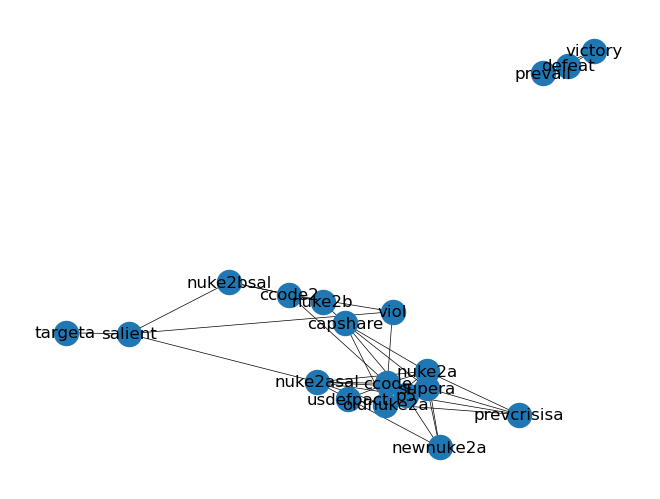

In [33]:
# run a network diagram on the correlation matrix

import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()


# correlation pairs are from the correlation matrix I ran earlier; all of these pairs had a correlation > 0.7 threshold
corr_data =([['ccode2', 'ccode', 0.30841024045462917], ['viol', 'ccode', 0.2026922159824842], ['viol', 'ccode2', 0.2026922159824858], ['nuke2a', 'ccode', -0.40744644063796565], ['nuke2b', 'ccode2', -0.40744644063796576], ['prevcrisisa', 'nuke2a', 0.32083498709947383], ['usdefpact', 'ccode', -0.3917843978845189], ['prevail', 'victory', 0.6915263671859481], ['defeat', 'victory', -0.340114913853267], ['defeat', 'prevail', -0.4918321700983117], ['salient', 'viol', 0.6034661490247829], ['nuke2asal', 'ccode', -0.21863364984252692], ['nuke2asal', 'nuke2a', 0.5593750943581695], ['nuke2asal', 'salient', 0.31991709133888946], ['nuke2bsal', 'ccode2', -0.21863364984252712], ['nuke2bsal', 'nuke2b', 0.5593750943581696], ['nuke2bsal', 'salient', 0.319917091338889], ['capshare', 'nuke2a', 0.39048314837903], ['capshare', 'nuke2b', -0.3904831467687262], ['targeta', 'salient', -0.21759319211322736], ['supera', 'ccode', -0.49541035534142525], ['supera', 'nuke2a', 0.6687781972015735], ['supera', 'prevcrisisa', 0.2972761778662245], ['supera', 'nuke2asal', 0.3492617771234751], ['supera', 'capshare', 0.3663367764357581], ['p5', 'ccode', -0.5418764668207503], ['p5', 'nuke2a', 0.7383916355893351], ['p5', 'prevcrisisa', 0.38068100432479746], ['p5', 'nuke2asal', 0.35654693908855134], ['p5', 'capshare', 0.3927503770146483], ['p5', 'supera', 0.7833411810006301], ['newnuke2a', 'nuke2a', 0.5555796348410867], ['newnuke2a', 'nuke2asal', 0.5166300101279937], ['newnuke2a', 'supera', 0.22754901572866368], ['newnuke2a', 'p5', 0.26382557990936945], ['oldnuke2a', 'ccode', -0.3961768052183014], ['oldnuke2a', 'nuke2a', 0.7746673086715926], ['oldnuke2a', 'prevcrisisa', 0.28195496162693573], ['oldnuke2a', 'nuke2asal', 0.27676851053256646], ['oldnuke2a', 'capshare', 0.35827271373546565], ['oldnuke2a', 'supera', 0.6276077410961128], ['oldnuke2a', 'p5', 0.683359740225451], ['nuke2ab', 'nuke2a', 0.4357592701845069], ['nuke2ab', 'nuke2b', 0.4357592701845065], ['nuke2ab', 'nuke2asal', 0.22869968344154695], ['nuke2ab', 'nuke2bsal', 0.22869968344154692], ['nuke2ab', 'supera', 0.3583427915564853], ['nuke2ab', 'p5', 0.32806897714074135], ['nuke2ab', 'newnuke2a', 0.2147840796433715], ['nuke2ab', 'oldnuke2a', 0.3583427915564857]])

corr_data = [[x[0],x[1],0.01**(x[2])] for x in corr_data]

existing_edges = {}
def build_graph(w, lev):
  if (lev > 5)  :
      return
  for z in corr_data:
     ind=-1 
     if z[0] == w:
         ind=0
         ind1=1
     if z[1] == w:
         ind ==1
         ind1 =0
     if ind == 0 or ind == 1:
         if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :
             G.add_node(str(corr_data[ind]))
             existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
             G.add_edge(w,str(corr_data[ind1]))
             build_graph(corr_data[ind1], lev+1)

existing_nodes = {}
def build_graph_for_all():
    count=0
    for d in corr_data:
        if (count > 40) :
            return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
             G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count=count + 1

build_graph_for_all()

pos = nx.spring_layout(G,weight='weight')
nx.draw(G,pos=pos, width=0.5, with_labels=True)

plt.savefig("path1.png")

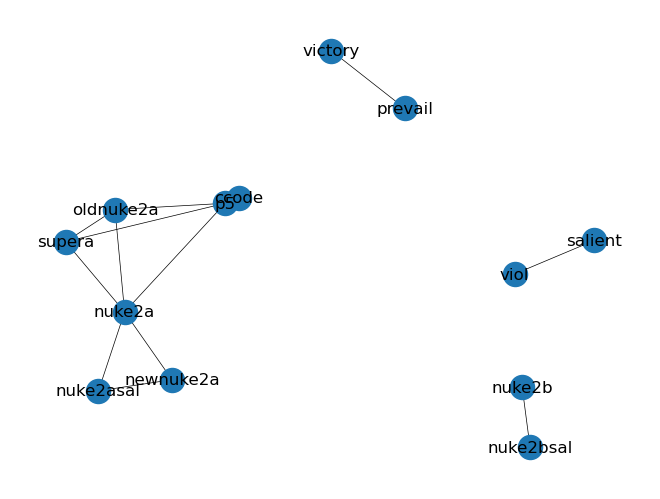

In [34]:
# run a network diagram on the correlation matrix, smaller subset of variables

import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()


# correlation pairs are from the correlation matrix I ran earlier; all of these pairs had a correlation > 0.7 threshold
corr_data =([['prevail', 'victory', 0.6915263671859481], ['salient', 'viol', 0.6034661490247829], ['nuke2asal', 'nuke2a', 0.5593750943581695], ['nuke2bsal', 'nuke2b', 0.5593750943581696], ['supera', 'nuke2a', 0.6687781972015735], ['p5', 'ccode', -0.5418764668207503], ['p5', 'nuke2a', 0.7383916355893351], ['p5', 'supera', 0.7833411810006301], ['newnuke2a', 'nuke2a', 0.5555796348410867], ['newnuke2a', 'nuke2asal', 0.5166300101279937], ['oldnuke2a', 'nuke2a', 0.7746673086715926], ['oldnuke2a', 'supera', 0.6276077410961128], ['oldnuke2a', 'p5', 0.683359740225451]])

corr_data = [[x[0],x[1],0.01**(x[2])] for x in corr_data]

existing_edges = {}
def build_graph(w, lev):
  if (lev > 5)  :
      return
  for z in corr_data:
     ind=-1 
     if z[0] == w:
         ind=0
         ind1=1
     if z[1] == w:
         ind ==1
         ind1 =0
     if ind == 0 or ind == 1:
         if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :
             G.add_node(str(corr_data[ind]))
             existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
             G.add_edge(w,str(corr_data[ind1]))
             build_graph(corr_data[ind1], lev+1)

existing_nodes = {}
def build_graph_for_all():
    count=0
    for d in corr_data:
        if (count > 40) :
            return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
             G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count=count + 1

build_graph_for_all()

pos = nx.spring_layout(G,weight='weight')
nx.draw(G,pos=pos, width=0.5, with_labels=True)

plt.savefig("path1.png")